<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_jul_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [118]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
train.shape, test.shape

((7111, 12), (2247, 9))

In [ ]:
base_train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv', 
                         index_col = 0)
base_train.index = base_train.index.astype('datetime64[ns]')
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv', 
                    index_col = 0)
train.index = train.index.astype('datetime64[ns]')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_test.csv', 
                   index_col = 0)
test.index = test.index.astype('datetime64[ns]')

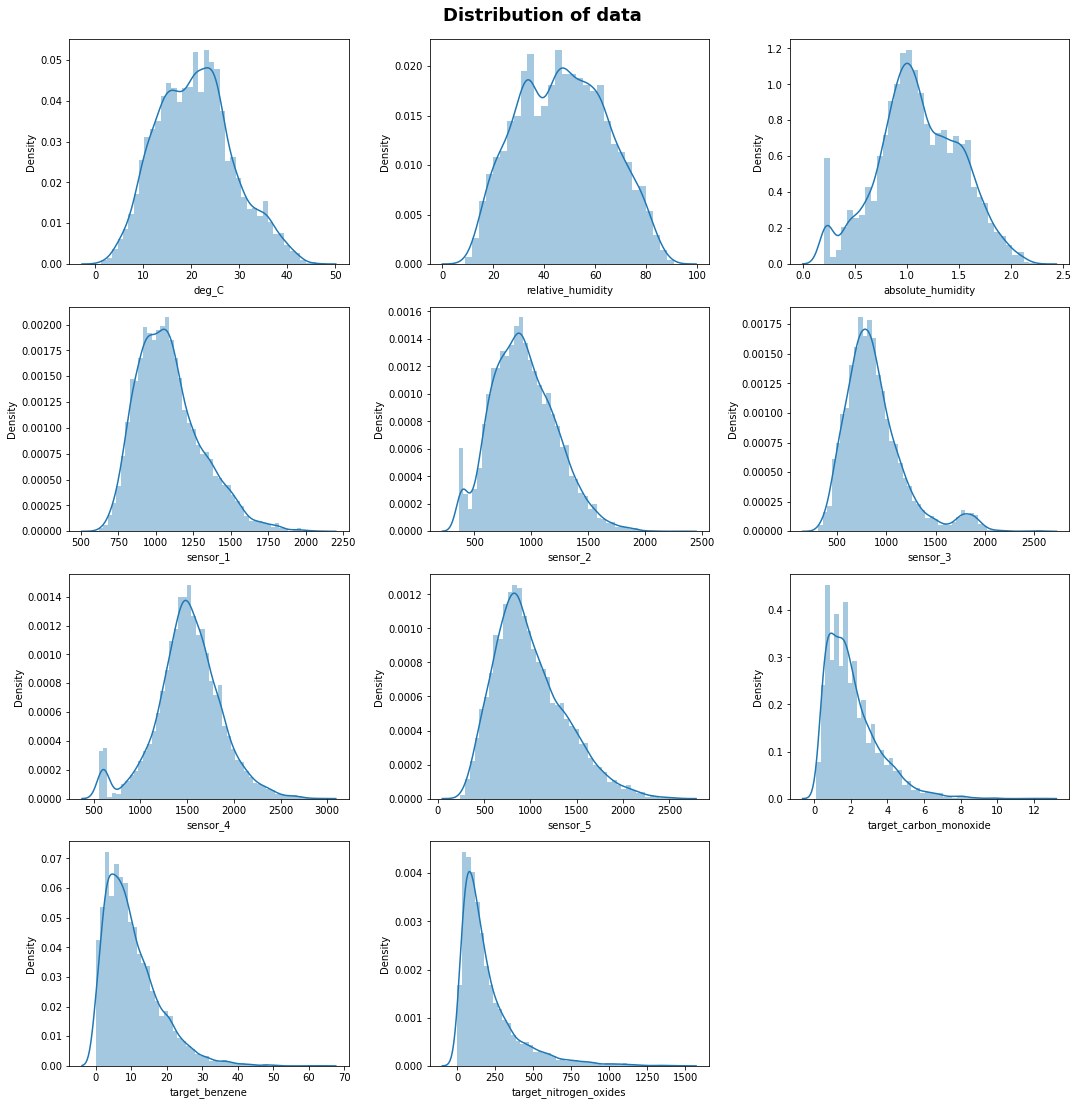

In [ ]:
plt.figure(figsize=(15,15))
for i,j in enumerate(train.select_dtypes('float').columns):
  plt.subplot(4,3, i+1)
  sns.distplot(train[j])
plt.suptitle('Distribution of data', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()


# target label이 3개 있는 시계열 데이터


date_time == 센서가 측정값을 내린 시간

deg_C == 온도

relative_humidity == 상대 습도 > 온도에 따라 달라짐

absolute_humidity == 절대 습도 > 온도가 증감 되더라도 가습 되지 않는 이상 절대 습도는 일정함

sensor_x == 센서 이름



In [119]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y-%m-%d %H:%M:%S')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y-%m-%d %H:%M:%S')

In [120]:
# train['date'] = train['date_time'].dt.date
# test['date'] = test['date_time'].dt.date

# train['month'] = train['date_time'].dt.month  # month넣으면 overfitting ==> 원핫코딩으로 없는 month컬럼을 따로 만들어 주어야 함
# test['month'] = test['date_time'].dt.month

train['day'] = train['date_time'].dt.day
test['day'] = test['date_time'].dt.day

train['hour'] = train['date_time'].dt.hour
test['hour'] = test['date_time'].dt.hour

train['weekday'] = train['date_time'].dt.weekday  # weekday를 카테고리로 해볼까
test['weekday'] = test['date_time'].dt.weekday

train['weekend'] = train['weekday'].apply(lambda x:1 if x in [5,6] else 0)
test['weekend'] = test['weekday'].apply(lambda x:1 if x in [5,6] else 0)

train['is_workingtime'] = train['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)
test['is_workingtime'] = test['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)

In [121]:
# SMC(포화 수증기량(?))

train['SMC'] = (train['absolute_humidity'] * 100) / train['relative_humidity']
test['SMC'] = (test['absolute_humidity'] * 100) / test['relative_humidity']

In [122]:
# object화
train['weekday'] = train['weekday'].astype('object')
test['weekday'] = test['weekday'].astype('object')

train['weekend'] = train['weekend'].astype('object')
test['weekend'] = test['weekend'].astype('object')

train['is_workingtime'] = train['is_workingtime'].astype('object')
test['is_workingtime'] = test['is_workingtime'].astype('object')

train['month'] = train['month'].astype('object')
test['month'] = test['month'].astype('object')

In [ ]:
# train = pd.get_dummies(train, columns=['month'])
# test = pd.get_dummies(test, columns=['month'])

In [123]:
# dew point(이슬점)
def dew_point(df):

  b = 17.62
  c = 243.12

  gamma = (b * df['deg_C'] /(c + df['deg_C'])) + np.log(df['relative_humidity'] / 100.0)
  dewpoint = (c * gamma) / (b - gamma)

  return dewpoint

train['dewpoint'] = dew_point(train)
test['dewpoint'] = dew_point(test)

In [117]:
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,day,hour,weekday,weekend,is_workingtime,SMC,dewpoint
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,10,18,2,0,1,1.647391,1.727907
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,10,19,2,0,1,1.601545,1.604653
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,10,20,2,0,1,1.334875,4.095906
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,10,21,2,0,0,1.260737,4.084138
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,10,22,2,0,0,1.336949,4.133561


Text(0.5, 1.0, 'date vs target')

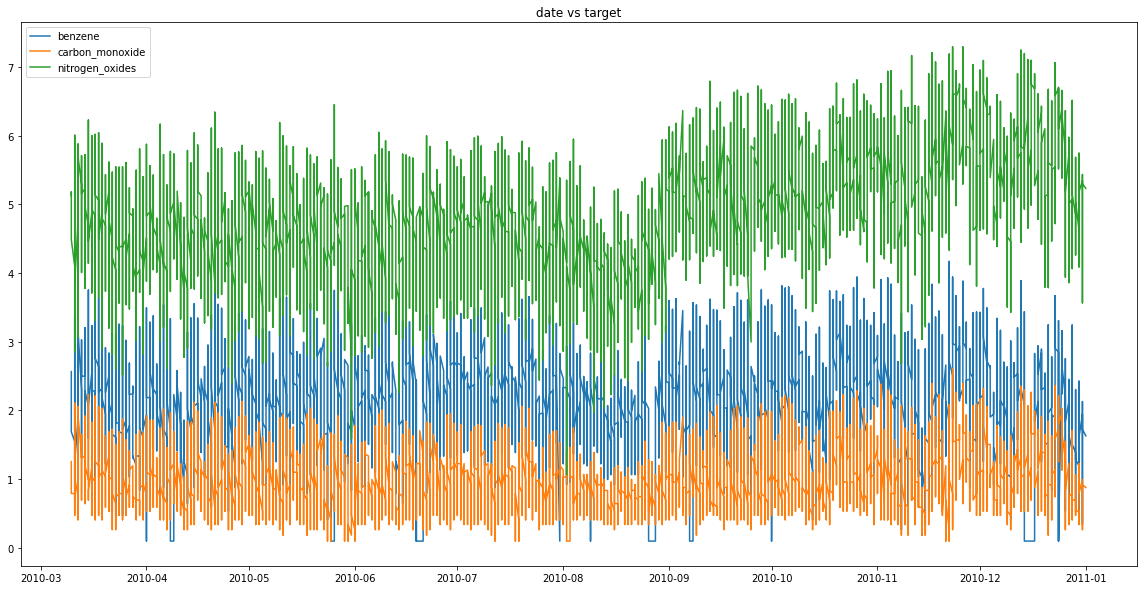

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train['date'], np.log1p(train['target_benzene']), label='benzene')
plt.plot(train['date'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.plot(train['date'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('date vs target')

Text(0.5, 1.0, 'deg_C vs target')

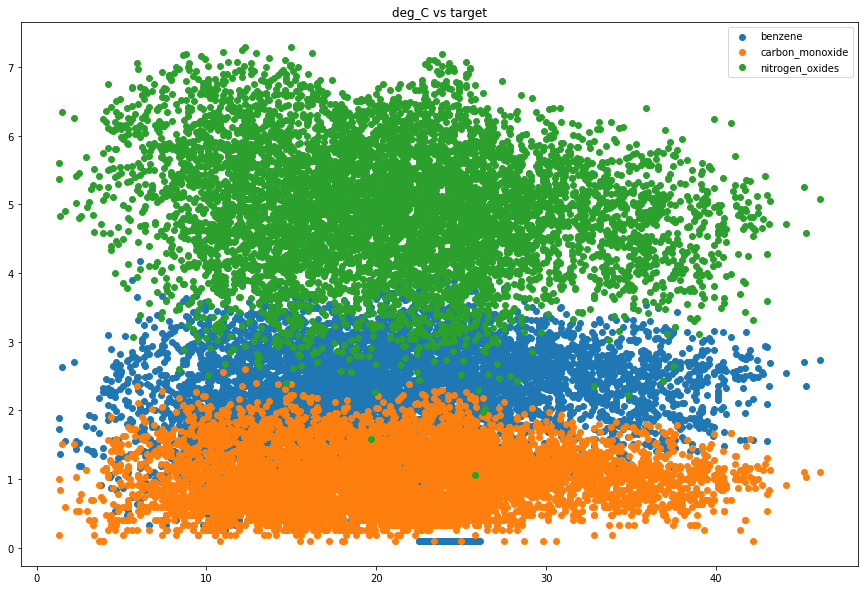

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['deg_C'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['deg_C'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['deg_C'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('deg_C vs target')

Text(0.5, 1.0, 'relative_humidity vs target')

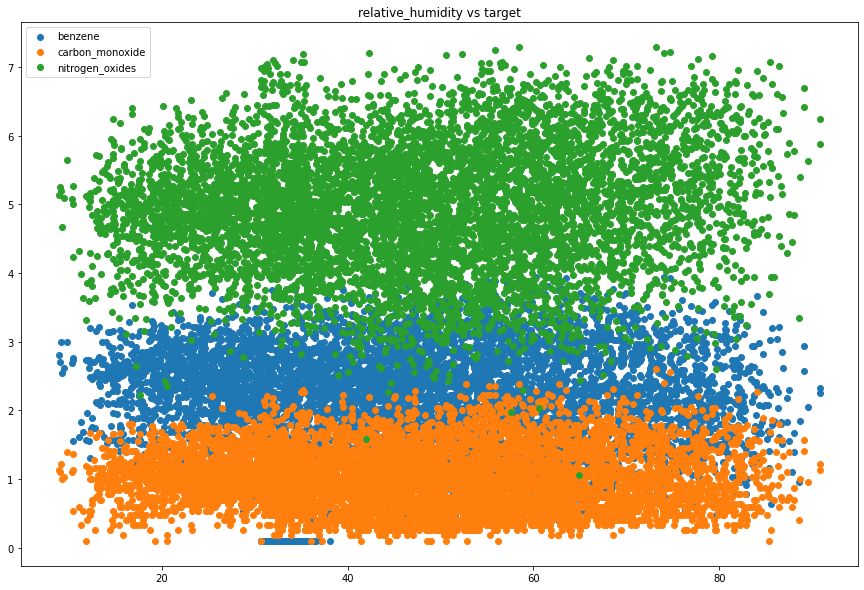

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['relative_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['relative_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['relative_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('relative_humidity vs target')

Text(0.5, 1.0, 'absolute_humidity vs target')

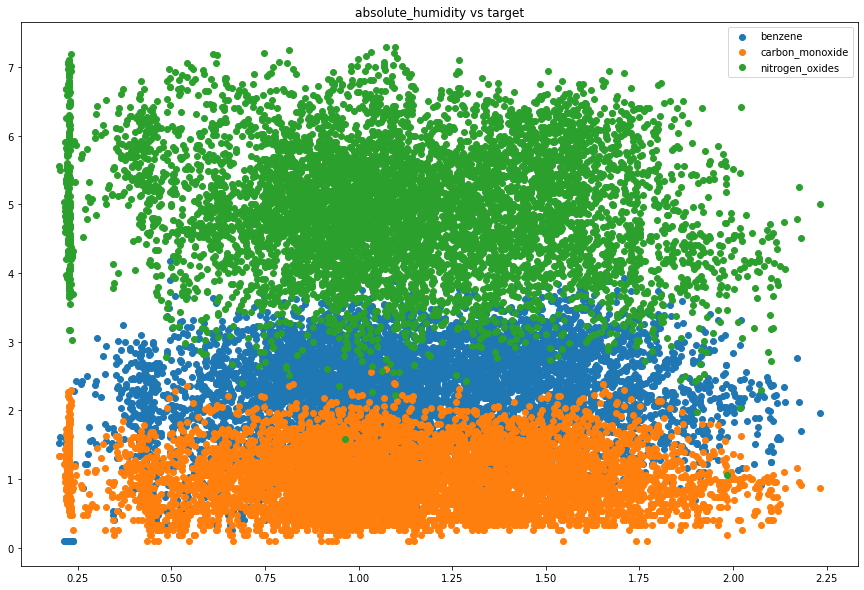

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['absolute_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['absolute_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['absolute_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('absolute_humidity vs target')

# 시각화를 통해
nitrigen_oxides는 날짜의 영향을 받는다(== 날씨의 영향을 받는다)

bengene, carbon은 날짜의 영향을 받지 않는듯하다(== 날씨의 영향을 덜 받는다)



---

# 시계열별 EDA



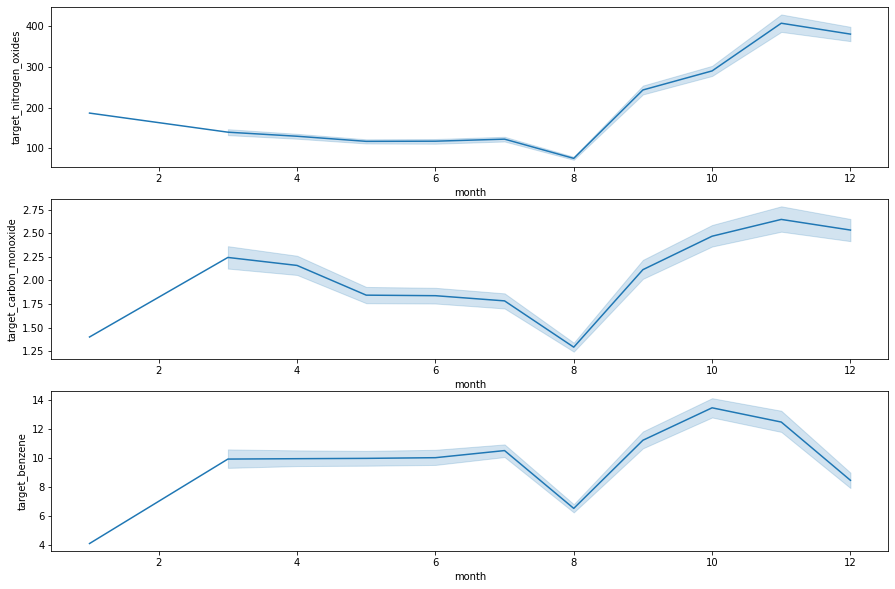

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,10))
sns.lineplot(train['month'], train['target_nitrogen_oxides'], ax=ax[0])
sns.lineplot(train['month'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['month'], train['target_benzene'], ax=ax[2])

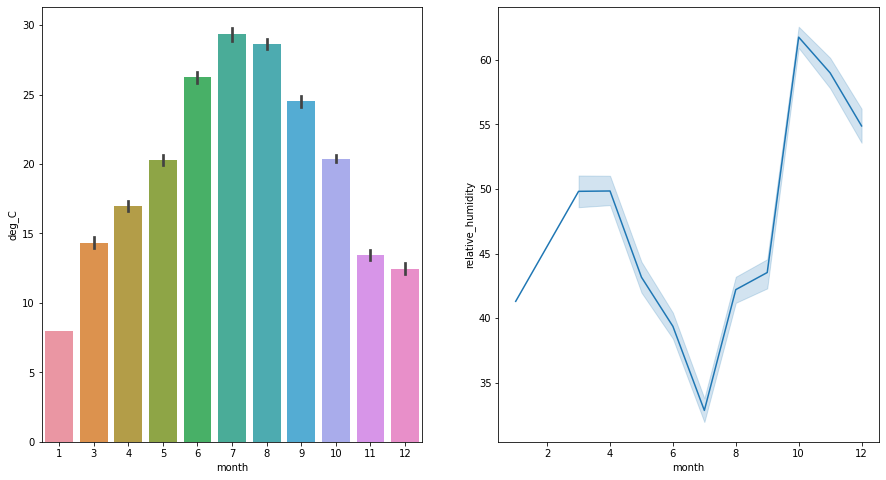

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
sns.barplot(train['month'], train['deg_C'], ax=ax[0])
sns.lineplot(train['month'], train['relative_humidity'], ax=ax[1])

여름에는 덥고 건조하고 겨울에는 춥고 습윤하다 ==> 지중해 날씨??

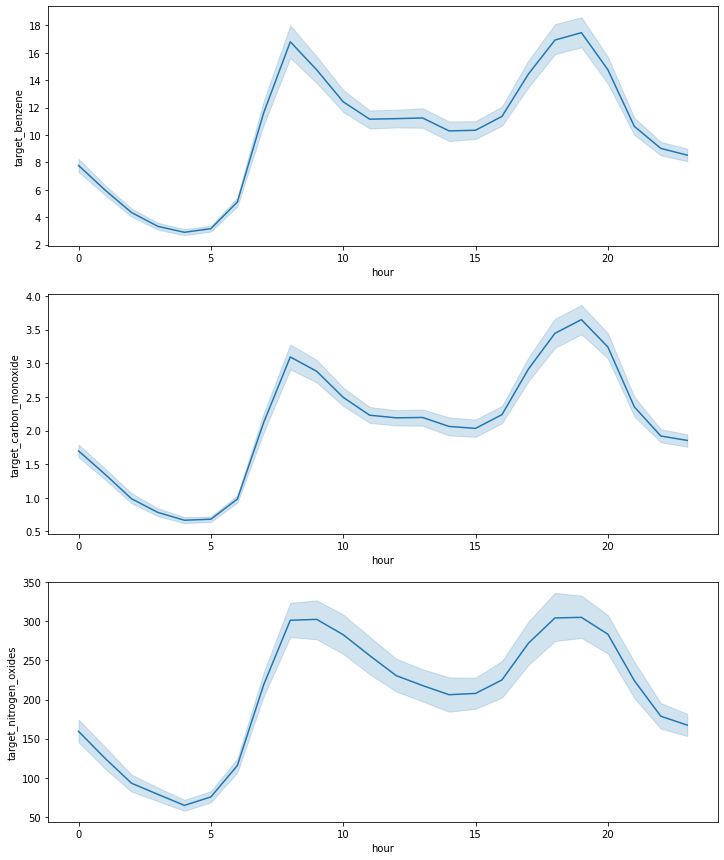

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.lineplot(train['hour'], train['target_benzene'], ax=ax[0])
sns.lineplot(train['hour'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['hour'], train['target_nitrogen_oxides'], ax=ax[2])

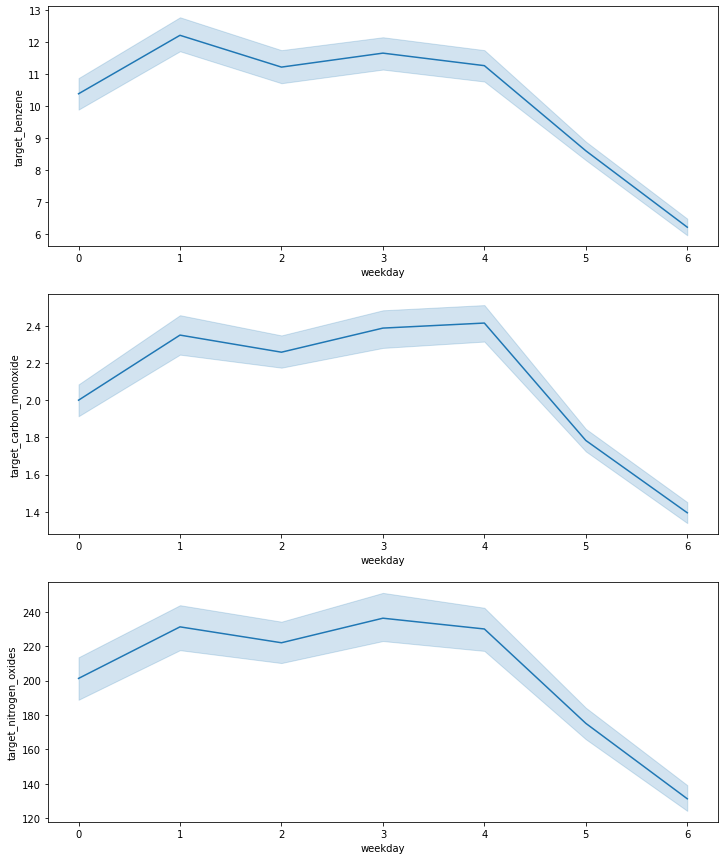

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.lineplot(train['weekday'], train['target_benzene'], ax=ax[0])
sns.lineplot(train['weekday'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['weekday'], train['target_nitrogen_oxides'], ax=ax[2])

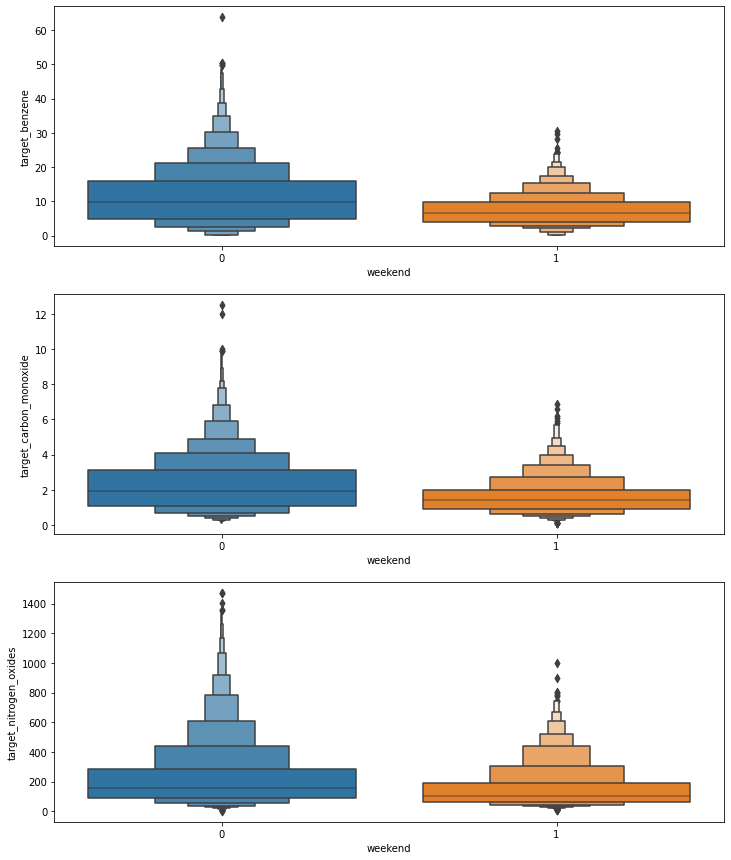

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.boxenplot(train['weekend'], train['target_benzene'], ax=ax[0])
sns.boxenplot(train['weekend'], train['target_carbon_monoxide'], ax=ax[1])
sns.boxenplot(train['weekend'], train['target_nitrogen_oxides'], ax=ax[2])

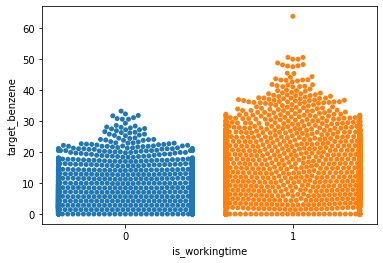

In [ ]:
sns.swarmplot(train['is_workingtime'], train['target_benzene'])

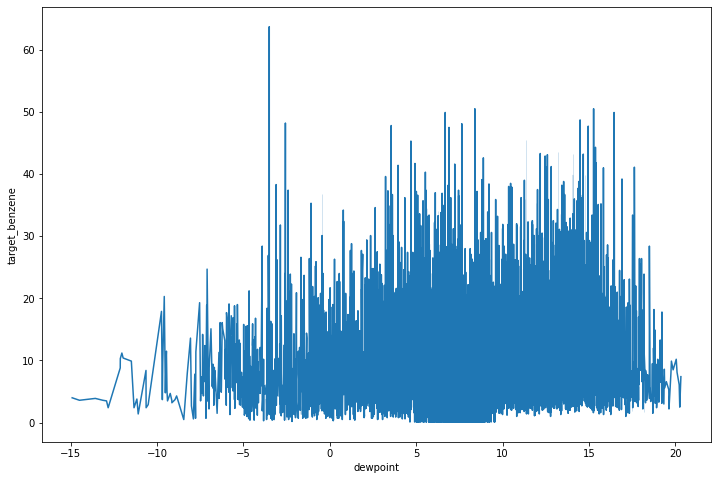

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(train['dewpoint'], train['target_benzene'])

hour 변수로 시각화해서 알 수 있는 것 ==> 시간 별로 target값이 불규칙하다 ==> 유의미한 column이다.

weekday 변수로 시각화해서 알 수 있는 것 ==> 유의미한 차이가 관찰됨 ==> 유의미한 column

weekend 변수로 시각화해서 알 수 있는 것 ==> 차이가 있다. ==> 유의미한 column

* 시계열 변수는 hour, weekday, weekend 변수만 챙겨간다.

In [8]:
pip install catboost

     |████████████████████████████████| 69.2MB 76kB/s 


In [9]:
pip install optuna

     |████████████████████████████████| 307kB 6.4MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 174kB 58.5MB/s 
     |████████████████████████████████| 143kB 57.0MB/s 
     |████████████████████████████████| 112kB 69.6MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 81kB 13.4MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=7b482a7a6cc7e39f22d89aa2c4d6dc5eeed2ae9d568cd0a3ba5d0bad48d2109a
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [37]:
import catboost
import xgboost
import lightgbm as lgbm
import optuna
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, train_test_split
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.preprocessing import robust_scale, StandardScaler, MinMaxScaler
rmsle = make_scorer(mean_squared_log_error, greater_is_better=False)

In [124]:
x_train = train.drop(columns=['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
y1_train = np.log1p(train['target_carbon_monoxide'])
y2_train = np.log1p(train['target_benzene'])
y3_train = np.log1p(train['target_nitrogen_oxides'])
x_test = test.drop(columns=['date_time'])

train_col = x_train.columns
test_col = x_train.columns

In [ ]:
x_train = train.drop(columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
y1_train = train['target_carbon_monoxide']
y2_train = train['target_benzene']
y3_train = train['target_nitrogen_oxides']
x_test = test.copy()

train_col = x_train.columns
test_col = x_train.columns

In [ ]:
for i in x_train.columns:
  if x_train[i].skew() > 0.5:
    x_train[i] = boxcox1p(x_train[i], boxcox_normmax(x_train[i]+1))
    x_test[i] = boxcox1p(x_test[i], boxcox_normmax(x_test[i]+1))

In [ ]:
# StandardScaler
sc = StandardScaler().fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [125]:
# MinMaxScaler
for i in x_train.select_dtypes(exclude='object').columns:
  sc = MinMaxScaler().fit(x_train[[i]])
  x_train[i] = sc.transform(x_train[[i]])
  x_test[i] = sc.transform(x_test[[i]])

In [126]:
x_train = pd.DataFrame(x_train, columns=train_col)
x_test = pd.DataFrame(x_test, columns=test_col)

([<matplotlib.axis.XTick at 0x7fe7ec9c78d0>,
 <a list of 19 Text major ticklabel objects>)

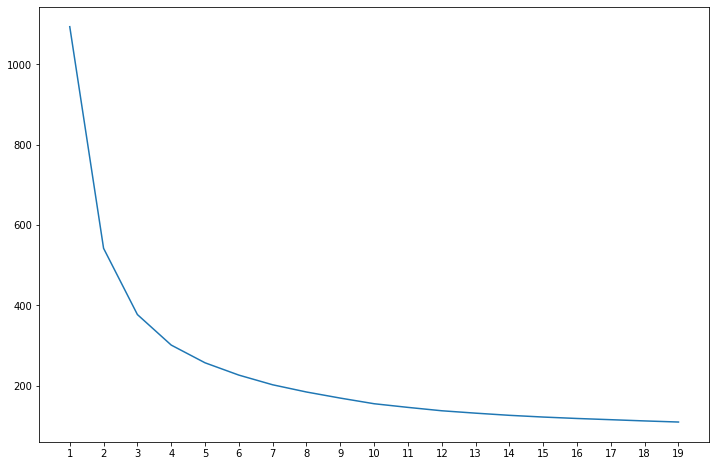

In [127]:
# sensor 클러스터링

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



train_cl = x_train[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']]
test_cl = x_test[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']]

data_cl = pd.concat([train_cl, test_cl])

cluster={}
for i in range(1, 20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, n_jobs=-1).fit(data_cl)
  cluster[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(cluster).index, pd.Series(cluster), markers='O')
plt.xticks(pd.Series(cluster).index)

In [128]:
km = KMeans(n_clusters=4, max_iter=1000, n_jobs=-1).fit(data_cl)

x_train['cluster'] = km.predict(train_cl)
x_test['cluster'] = km.predict(test_cl)

In [130]:
x_train['cluster'] = x_train['cluster'].astype('object')
x_test['cluster'] = x_test['cluster'].astype('object')

In [ ]:
# 성능 안좋음
# x_train = pd.DataFrame(robust_scale(x_train), columns=train_col)
# x_test = pd.DataFrame(robust_scale(x_test), columns=test_col)

In [137]:
train['cluster'] = km.predict(train_cl)
test['cluster'] = km.predict(test_cl)

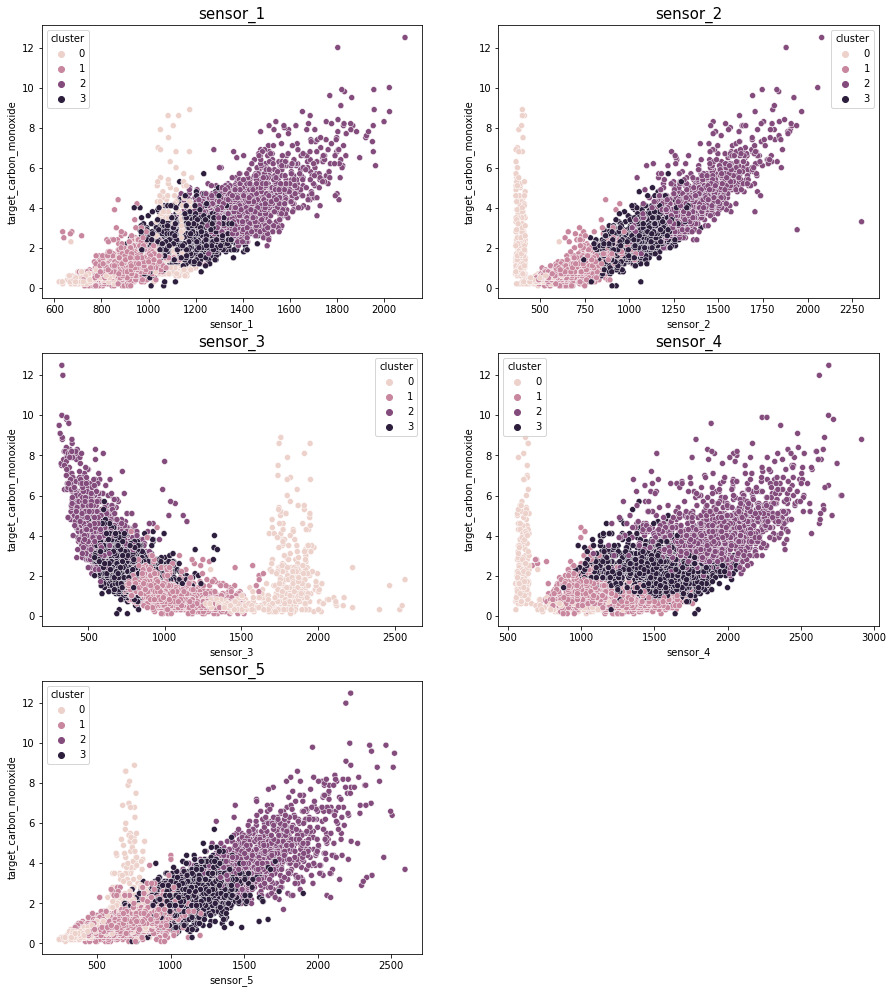

In [159]:
plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_carbon_monoxide'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

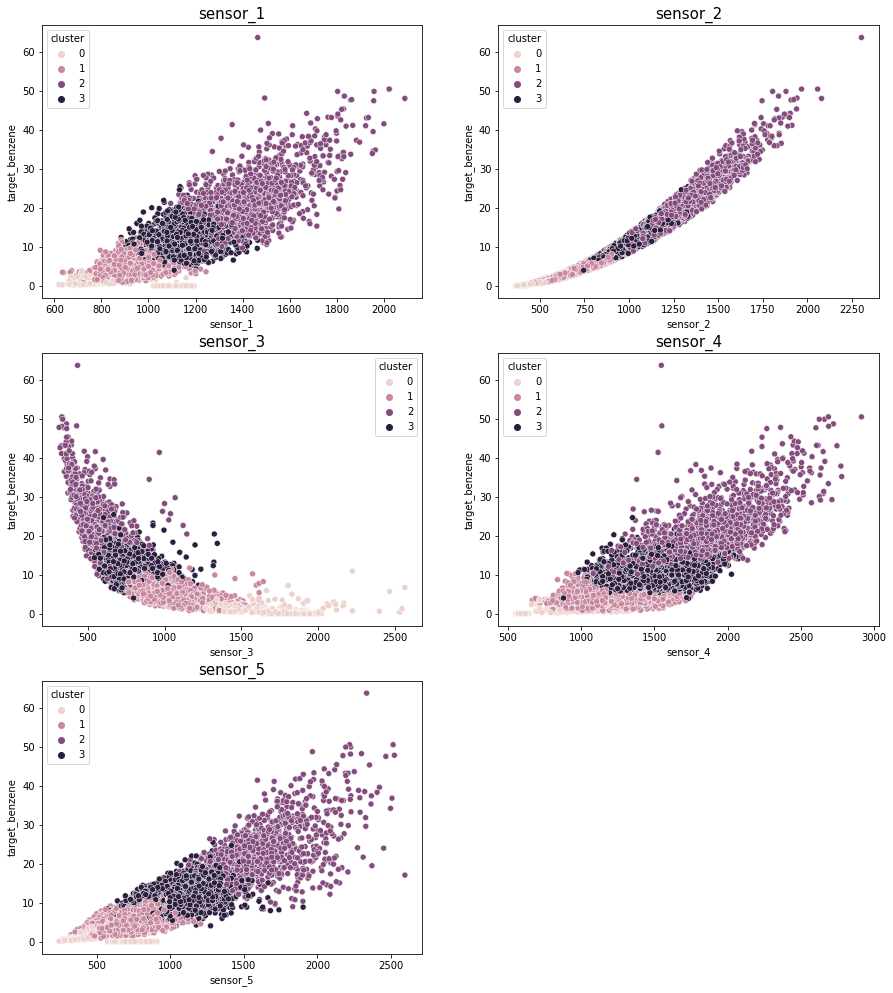

In [160]:
plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_benzene'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

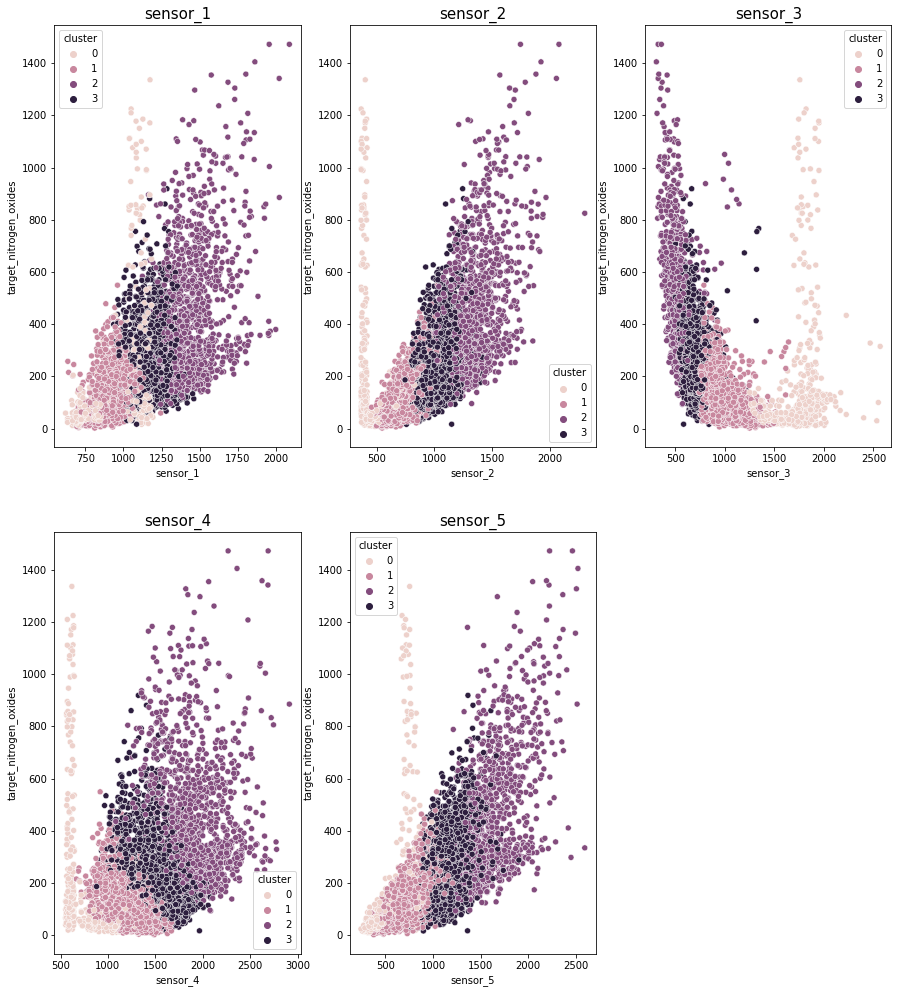

In [172]:
plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_nitrogen_oxides'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

# target : carbon_monoxide 모델링

In [183]:
cat_features = x_train.select_dtypes('object').columns

def objective(trial,data=x_train,target=y1_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-07-09 12:11:55,719] A new study created in memory with name: no-name-aaf3c0fd-e269-48ae-97b6-ca14d5a56b5f
[I 2021-07-09 12:12:23,119] Trial 0 finished with value: 0.053803654715346615 and parameters: {'iterations': 8887, 'learning_rate': 0.4190755859643239, 'reg_lambda': 32.5041033278722, 'subsample': 0.2608918742519606, 'random_strength': 42.589749505658446, 'depth': 5, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 15}. Best is trial 0 with value: 0.053803654715346615.
[I 2021-07-09 12:12:27,526] Trial 1 finished with value: 0.05223133027394168 and parameters: {'iterations': 3517, 'learning_rate': 0.295476169374844, 'reg_lambda': 8.702466742749168, 'subsample': 0.9523629428178811, 'random_strength': 29.33168256896712, 'depth': 11, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 6}. Best is trial 1 with value: 0.05223133027394168.
[I 2021-07-09 12:12:32,541] Trial 2 finished with value: 0.05332611383227652 and parameters: {'iterations': 5881, 'learning_rate': 0.398

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
kf = KFold(n_splits=7, shuffle=False, random_state=42)
preds_cat_1 = np.zeros((x_test.shape[0],))
param_y1 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(kf.split(x_train, y1_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y1_train.iloc[train_index], y1_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**param_y1)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_1 += model_cat.predict(x_test)/kf.n_splits
  preds_cat_val = model_cat.predict(X_valid)
  RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
  print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

# target_benzene 모델링

In [ ]:
def objective(trial,data=x_train,target=y2_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
kf = KFold(n_splits=7, shuffle=False, random_state=42)
preds_cat_2 = np.zeros((x_test.shape[0],))
param_y2 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(kf.split(x_train, y2_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y2_train.iloc[train_index], y2_train.iloc[valid_index]

  model_cat2 = catboost.CatBoostRegressor(**param_y2, use_best_model=True)
  model_cat2.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_2 += model_cat2.predict(x_test) / kf.n_splits
  preds_cat_val = model_cat2.predict(X_valid)
  RMSLE = mean_squared_log_error(np.exp(Y_valid), np.exp(preds_cat_val))
  print(f'RMSLE:{np.sqrt(RMSLE)}')

In [31]:
pd.Series(np.expm1(preds_cat_2)).value_counts().sort_index()

0.098890     1
0.099110     1
0.099313     1
0.099829     1
0.099838     1
            ..
35.472651    1
37.401886    1
38.946693    1
39.251716    1
40.823077    1
Length: 2247, dtype: int64

# target_nitrogen_oxides 모델링

In [ ]:
def objective(trial,data=x_train,target=y3_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
kf = KFold(n_splits=7, shuffle=False, random_state=42)
preds_cat_3 = np.zeros((x_test.shape[0]))
param_y3 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(kf.split(x_train, y3_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y3_train.iloc[train_index], y3_train.iloc[valid_index]

  model_cat3 = catboost.CatBoostRegressor(**param_y3)
  model_cat3.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_3 += model_cat3.predict(x_test)/kf.n_splits
  preds_cat_val = model_cat3.predict(X_valid)
RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
submit = submit.set_index('date_time')

submit['target_carbon_monoxide'] = np.expm1(preds_cat_1)
submit['target_benzene'] = np.expm1(preds_cat_2)
submit['target_nitrogen_oxides'] = np.expm1(preds_cat_3)

submit

In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/submit19.csv')

# conclusion

* 시계열 feature 들은 day, hour, weekday, weekend로 만족
* month는 overfitting
* shuffle = False로 하니까 점수 상승(?)
* object화 하니까 점수 상승
* dewpoint(이슬점) 만드니까 소폭 상승

# To_do
 * 시계열 데이터 이니까 shuffle=False로 하고 해보자
 
 * clustering하고 제출

 * LeaveOneGroupOut 사용해보기

 * 다른 모델 써보기

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
submit = submit.set_index('date_time')

submit['target_carbon_monoxide'] = preds_cat_1
submit['target_benzene'] = preds_cat_2
submit['target_nitrogen_oxides'] = preds_cat_3

submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/submit9.csv')